In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install tensorflow-addons
!unzip drive/MyDrive/MURA-v1.1.zip

In [ ]:
import os 
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score, classification_report
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet169

### Functions and Classes that will be used throughout this notebook

In [ ]:
def label_count(labels_df):
    """
    Counts the number of X-Ray labels for each body part
    """
    img_label_count = {}

    for xr_type in list(pd.unique(labels_df.XR_type)):
        tmp = labels_df.loc[labels_df.XR_type == xr_type]
        normal, abnormal = 0, 0

        for i in range(len(tmp)):
            if tmp.iloc[i, 3] == 1:
                abnormal += 1
            else:
                normal += 1

        img_label_count[xr_type] = {}
        img_label_count[xr_type]['normal'] = normal
        img_label_count[xr_type]['abnormal'] = abnormal

    return img_label_count

def plot_label_counts(count_dict, labels_df):
    """
    Plots the label counts for each body part
    """
    fig = plt.figure(figsize=(23,10))
    fig.patch.set_alpha(1)

    for i, xr_type in enumerate(pd.unique(labels_df.XR_type)):
        keys = list(count_dict[xr_type].keys())
        values = list(count_dict[xr_type].values())

        ax = fig.add_subplot(2, 4, i+1)
        bars = ax.bar(x=keys, height=values, color='#270074')
        ax.set_ylim(0, max(count_dict[max(count_dict)].values())+500)
        #ax.bar_label(bars, size=13)
        ax.set_title(f'{xr_type[3:]} X-RAYs', size=14)
        ax.set_ylabel('Count', size=13)
        ax.tick_params(axis='x', which='major', labelsize=13)
        for i in range(len(count_dict[xr_type].values())):
            plt.annotate(str(values[i]), xy=(keys[i],values[i]), ha='center', va='bottom', size=13)

    return plt.show()

In [ ]:
class ReturnBestEarlyStopping(EarlyStopping):
    """
    If the maximum epoch is reached, then retain the best performing weights.
    """
    def __init__(self, **kwargs):
        super(ReturnBestEarlyStopping, self).__init__(**kwargs)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            if self.verbose > 0:
                print(f'\nEpoch {self.stopped_epoch + 1}: early stopping')
        elif self.restore_best_weights:
            if self.verbose > 0:
                print('Restoring model weights from the end of the best epoch.')
            self.model.set_weights(self.best_weights)

In [ ]:
# Helper functions for plots
def plot_history(history):
    """
    Plots training history
    """
    fig = plt.figure(figsize=(20,5))
    fig.suptitle("Training/Validation Results", fontsize=17)
    fig.patch.set_alpha(1)

    for i in range(0, 3):
        ax = fig.add_subplot(1,3,i+1)
        ax.plot(history[list(history.keys())[i]], c='r', 
                label='Training Loss' if i==0 else 'Training Cohen Kappa' if i==1 else 'Training Accuracy')
        ax.plot(history[list(history.keys())[i+3]], c='k',
                label='Validation Loss' if i==0 else 'Validation Cohen Kappa' if i==1 else 'Validation Accuracy')
        ax.legend(fontsize=11, loc='lower right' if i in [1,2] else 'upper right')
        ax.set_xlabel('Epochs', fontsize=14)
        ax.set_ylabel('Loss' if i==0 else 'Cohen Kappa' if i==1 else 'Accuracy', fontsize=15)
    return plt.show()

def plot_cm(true_labels, predicted_labels, title):
    """
    Plots the confusion matrix
    """
    fig = plt.figure(figsize=(20,7))
    fig.patch.set_alpha(1)
    fig.suptitle(f'Confusion Matrices for the two sets of {title[3:].capitalize()} Predictions', fontsize=18)

    for i, preds in enumerate(predicted_labels):
        cm = confusion_matrix(true_labels, preds)
        ax = fig.add_subplot(1, 2, i+1)
        sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="YlGnBu",  annot_kws={"size":14}, 
                    yticklabels=['Normal', 'Abnormal'], xticklabels=['Normal', 'Abnormal']);  #annot=True to annotate cells, ftm='g' to disable scientific notation
        ax.set_xlabel('Predicted labels', fontsize=15);ax.set_ylabel('True labels', fontsize=15)
        ax.set_title('Confusion Matrix of CNN\'s Predictions' if i==0 else 'Confusion Matrix of DenseNet\'s Predictions', size=14)
    return plt.show()

def kappa_bodypart_plot(test_data, cnn_label_preds, densenet_label_preds):
    """
    Plots the cohen kappa scores for each body part
    """
    kappas = {}
    for bodypart in pd.unique(test_data.XR_type):
        # fill dictionary with the cohen kappa score of each bodypart
        cnn_bodypart = cnn_label_preds[test_data.loc[test_data.XR_type == bodypart].index].reshape(-1,)
        densenet_bodypart = densenet_label_preds[test_data.loc[test_data.XR_type == bodypart].index].reshape(-1,)

        true_bodypart = test_data.loc[test_data.XR_type == bodypart].label.to_numpy().astype(int)
        kappas[bodypart[3:]] = [cohen_kappa_score(true_bodypart, cnn_bodypart),
                            cohen_kappa_score(true_bodypart, densenet_bodypart)]

    k = [key for key in kappas.keys()]
    v = [value for value in kappas.values()]

    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot()
    ax.bar(np.arange(len(k)) - 0.2, [value[0] for value in v],
        width=0.2, color='#3D85F7', align='center', label='CNN',
        zorder=3)
    ax.bar(np.arange(len(k)) + 0.2,
        [value[1] if len(value) == 2 else 0 for value in v],
        width=0.2, color='#C32E5A', align='center', label='DenseNet',
        zorder=3)
    ax.set_xticklabels(k)
    ax.set_xticks(np.arange(len(k)))
    ax.grid(zorder=0)
    ax.legend()
    ax.set_title('Cohen Kappas for Each Bodypart', size=15);
    
    return plt.show()

def roc_auc_plot(true_labels, predicted_labels, title):
    """
    Plots the ROC curves
    """
    fig = plt.figure(figsize=(15,5))
    fig.patch.set_alpha(1)

    for i, preds in enumerate(predicted_labels):
        fpr, tpr, thresholds = roc_curve(true_labels, preds)
        auc_value = auc(fpr, tpr)

        ax = fig.add_subplot(1, 2, i+1)
        ax.plot([0,1], [0,1], '--', color='k', label='Baseline')
        ax.plot(fpr, tpr, marker='.', color='#C32E5A', label=f"ROC Curve (area = {round(auc_value,3)})")
        ax.set_xlabel('False Positive Rate', fontsize=13)
        ax.set_ylabel('True Positive Rate', fontsize=13)
        ax.set_title(f"{title[i]} ROC Curve", fontsize=14)
        ax.legend(loc='lower right', fontsize=12)

    return plt.show()

In [ ]:
def bodypart_errors(cnn_label_preds, densenet_label_preds, test_labels, bodypart):
    """
    Error analysis function
    """
    cnn_bodypart = cnn_label_preds[test_labels.loc[test_labels.XR_type == bodypart].index].reshape(-1,)
    densenet_bodypart = densenet_label_preds[test_labels.loc[test_labels.XR_type == bodypart].index].reshape(-1,)
    true_bodypart = test_labels.loc[test_labels.XR_type == bodypart].label.to_numpy().astype(int)

    print(f'CNN cohen kappa: {cohen_kappa_score(true_bodypart, cnn_bodypart)}')
    print(f'Densenet cohen kappa: {cohen_kappa_score(true_bodypart, densenet_bodypart)}\n')

    print(f'CNN\'s Classification Report:\n{classification_report(true_bodypart, cnn_bodypart)}\n')
    print(f'DenseNet\'s Classification Report:\n{classification_report(true_bodypart, densenet_bodypart)}\n')

    return plot_cm(true_bodypart, [cnn_bodypart, densenet_bodypart], bodypart)

### Preprocessing

In [ ]:
# read labels
train_labels = pd.read_csv('MURA-v1.1/train_labeled_studies.csv', header=None, names=['path', 'label'])
test_labels = pd.read_csv('MURA-v1.1/valid_labeled_studies.csv', header=None, names=['path', 'label'])
train_labels.head()

,path,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study...,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study...,1


In [ ]:
train_labels['XR_type'] = train_labels.path.apply(lambda x: re.findall(r'/(\w+)', x)[1])  # Create a new column with the type of x-ray
test_labels['XR_type'] = test_labels.path.apply(lambda x: re.findall(r'/(\w+)', x)[1])  

In [ ]:
train_labels.head()

,path,label,XR_type
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,1,XR_SHOULDER
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,1,XR_SHOULDER
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study...,1,XR_SHOULDER
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study...,1,XR_SHOULDER
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study...,1,XR_SHOULDER


In [ ]:
# Read image paths
train_image_paths = pd.read_csv('MURA-v1.1/train_image_paths.csv', header=None, names=['img_path'])
test_image_paths = pd.read_csv('MURA-v1.1/valid_image_paths.csv', header=None, names=['img_path'])

In [ ]:
print(f'There are {train_image_paths.shape[0]} unique train X-RAYs and {test_image_paths.shape[0]} unique test X-RAYs')

There are 36808 unique train X-RAYs and 3197 unique test X-RAYs


In [ ]:
# Extract more information for each image
train_image_paths['patient'] = train_image_paths.img_path.apply(lambda x: re.findall(r'/(\w+)', x)[2])
train_image_paths['path'] = train_image_paths.img_path.apply(lambda x: '/'.join(x.split('/')[:-1]) + '/')
train_image_paths['img'] = train_image_paths.img_path.apply(lambda x: x.split('/')[-1])

test_image_paths['patient'] = test_image_paths.img_path.apply(lambda x: re.findall(r'/(\w+)', x)[2])
test_image_paths['path'] = test_image_paths.img_path.apply(lambda x: '/'.join(x.split('/')[:-1]) + '/')
test_image_paths['img'] = test_image_paths.img_path.apply(lambda x: x.split('/')[-1])

In [ ]:
train_image_paths.head()

,img_path,patient,path,img
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,patient00001,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,image1.png
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,patient00001,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,image2.png
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,patient00001,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,image3.png
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,patient00002,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,image1.png
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,patient00002,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,image2.png


In [ ]:
# Create the final dataframes
train_data = pd.merge(train_image_paths, train_labels, left_on='path', right_on='path')
train_data.drop(columns=['path'], inplace=True)

test_data = pd.merge(test_image_paths, test_labels, left_on='path', right_on='path')
test_data.drop(columns=['path'], inplace=True)

In [ ]:
train_data.head()

,img_path,patient,img,label,XR_type
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,patient00001,image1.png,1,XR_SHOULDER
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,patient00001,image2.png,1,XR_SHOULDER
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study...,patient00001,image3.png,1,XR_SHOULDER
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,patient00002,image1.png,1,XR_SHOULDER
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study...,patient00002,image2.png,1,XR_SHOULDER


In [ ]:
test_data.head()

,img_path,patient,img,label,XR_type
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,patient11185,image1.png,1,XR_WRIST
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,patient11185,image2.png,1,XR_WRIST
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,patient11185,image3.png,1,XR_WRIST
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...,patient11185,image4.png,1,XR_WRIST
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...,patient11186,image1.png,1,XR_WRIST


### EDA

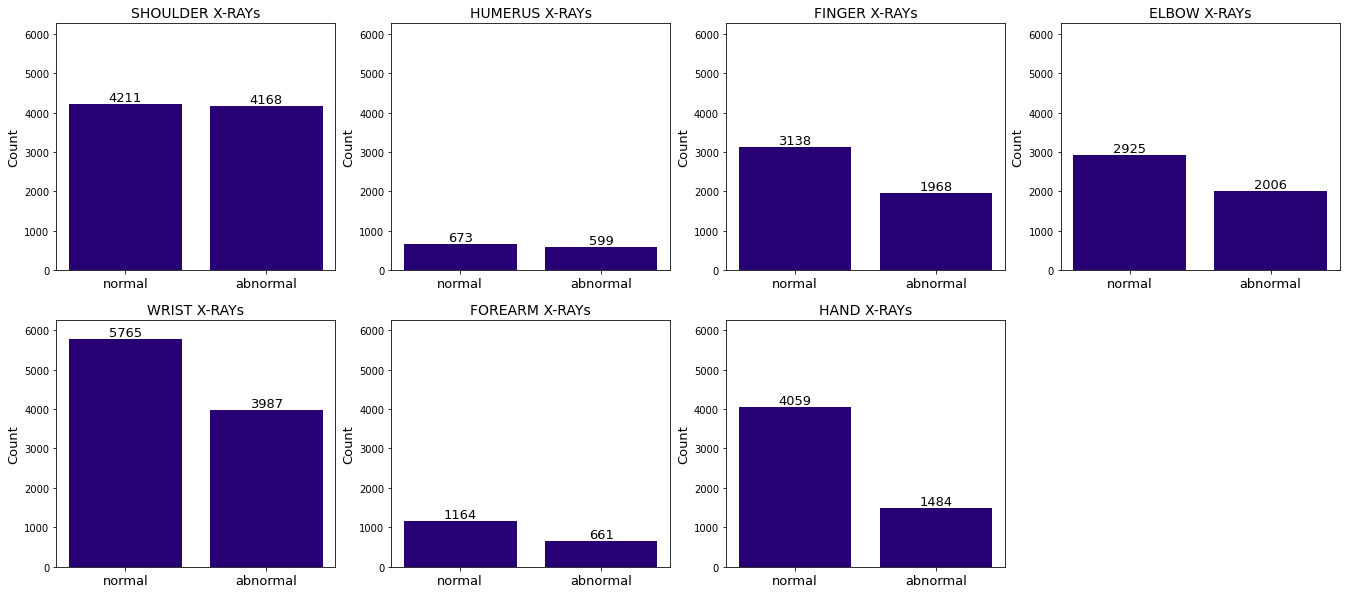

In [ ]:
train_label_count = label_count(train_data)
plot_label_counts(train_label_count, train_data)

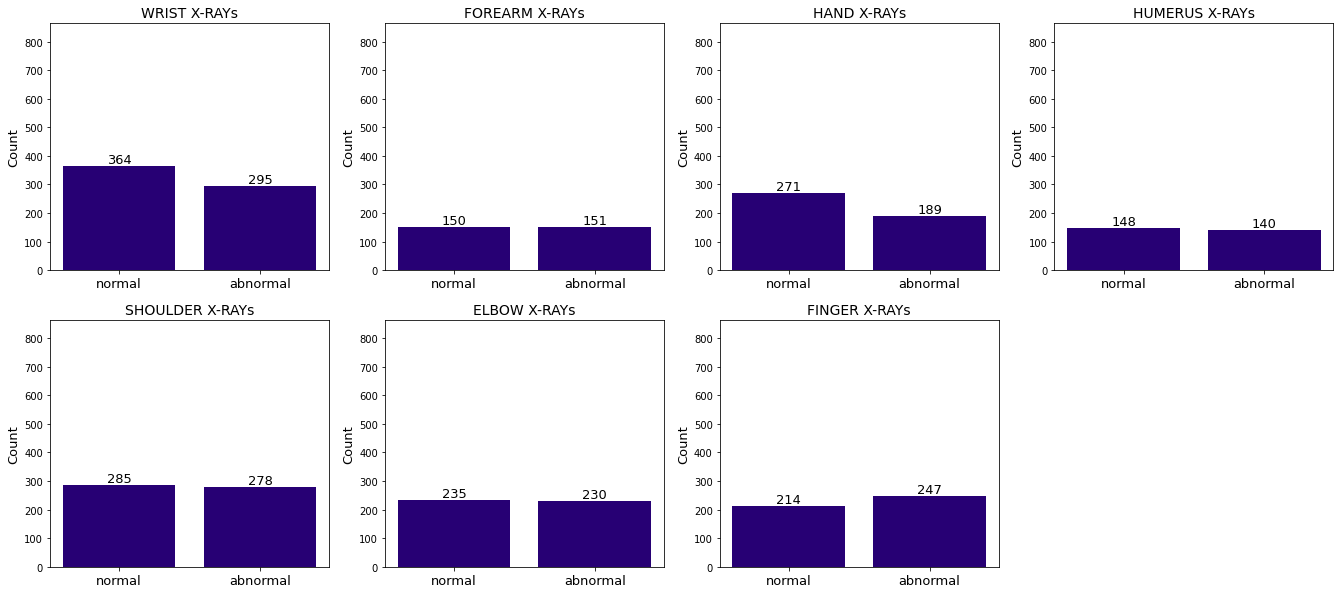

In [ ]:
test_label_count = label_count(test_data)
plot_label_counts(test_label_count, test_data)

In [ ]:
train_data = train_data.sample(frac=1).reset_index(drop=True)  #shuffle train dataframe
train_data.head()

,img_path,patient,img,label,XR_type
0,MURA-v1.1/train/XR_FINGER/patient02258/study1_...,patient02258,image1.png,0,XR_FINGER
1,MURA-v1.1/train/XR_HUMERUS/patient01048/study1...,patient01048,image2.png,1,XR_HUMERUS
2,MURA-v1.1/train/XR_FINGER/patient03312/study1_...,patient03312,image3.png,1,XR_FINGER
3,MURA-v1.1/train/XR_WRIST/patient05513/study1_p...,patient05513,image2.png,1,XR_WRIST
4,MURA-v1.1/train/XR_WRIST/patient06437/study1_p...,patient06437,image1.png,1,XR_WRIST


In [ ]:
row_shape, col_shape = [], []
for i in range(len(train_data)):
    img = cv2.imread(train_data.iloc[i,0])
    row_shape.append(img.shape[0])
    col_shape.append(img.shape[1])

print(f'Max height: {max(row_shape)}\nMin height: {min(row_shape)}\nMean height: {np.mean(row_shape)}\n')
print(f'Max width: {max(col_shape)}\nMin width: {min(col_shape)}\nMean width: {np.mean(col_shape)}')

Max height: 512
Min height: 132
Mean height: 491.0258367746142

Max width: 512
Min width: 89
Mean width: 399.32058248206914


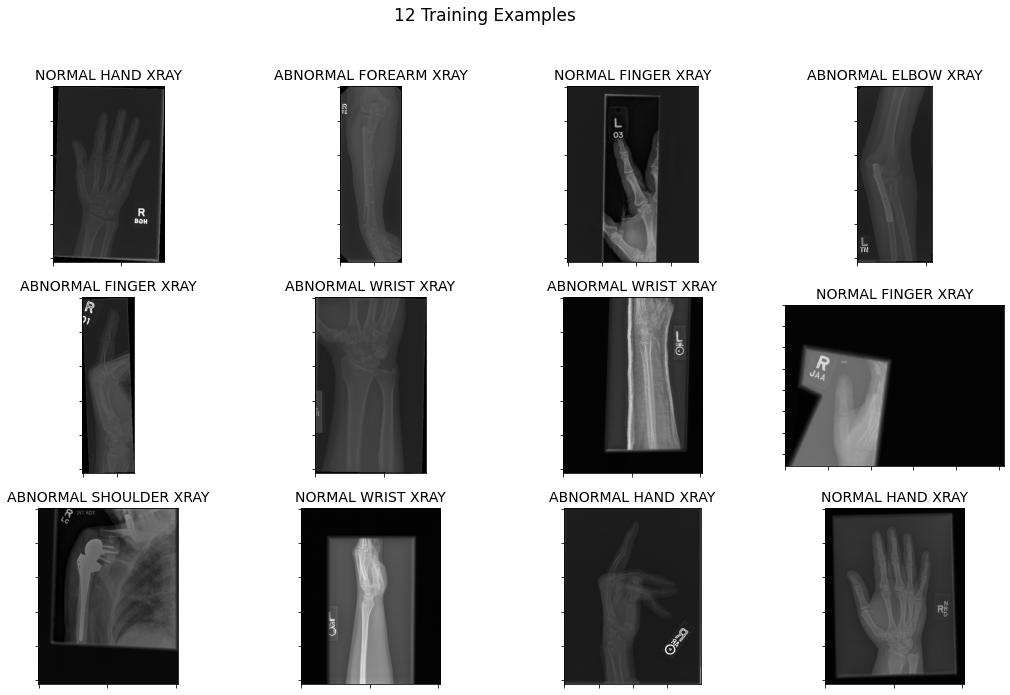

In [ ]:
fig = plt.figure(figsize=(18,11))
fig.patch.set_alpha(1)
fig.suptitle('12 Training Examples', size=17)

ab, nor = 'ABNORMAL', 'NORMAL'
for i in range(12):
    img = cv2.imread(train_data.iloc[i,0])
    ax = fig.add_subplot(3,4,i+1)
    ax.imshow(img)
    ax.set_title(f'{ab if train_data.iloc[i,3] else nor} {train_data.iloc[i,4][3:]} XRAY', size=14)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

#### Generator

In [ ]:
train_data['label'] = train_data['label'].astype(str)  # for the generator
test_data['label'] = test_data['label'].astype(str)

In [ ]:
train, val = train_test_split(train_data, test_size=0.15, random_state=42, stratify=train_data.label)

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    horizontal_flip=True,
    rotation_range=30,
    fill_mode='constant'
)

# do not augment validation and test sets
val_test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='img_path',
    y_col='label',
    batch_size=64,
    seed=42,
    shuffle=True,
    class_mode='binary',
    target_size=(224,224)
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val,
    x_col='img_path',
    y_col='label',
    batch_size=64,
    seed=42,
    shuffle=True,
    class_mode='binary',
    target_size=(224,224)
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='img_path',
    y_col='label',
    batch_size=64,
    class_mode='binary',
    target_size=(224,224),
    shuffle=False  # important for the metrics
)

Found 31286 validated image filenames belonging to 2 classes.
Found 5522 validated image filenames belonging to 2 classes.
Found 3197 validated image filenames belonging to 2 classes.


In [ ]:
METRICS = [
           tfa.metrics.CohenKappa(name="cohen_kappa", num_classes=2),
           'accuracy'
]

### CNN

In [ ]:
input = Input(shape=(224, 224, 3))

#block1
conv1 = Conv2D(filters=128, kernel_size=5, padding='same', activation='relu')(input)
bn1 = BatchNormalization()(conv1)
mpool0 = MaxPooling2D(pool_size=(2,2))(bn1)
conv2 = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(mpool0)
bn2 = BatchNormalization()(conv2)
mpool1 = MaxPooling2D(pool_size=(2,2))(bn2)
drpt1 = Dropout(0.35)(mpool1)

#block2
conv3 = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(drpt1)
bn3 = BatchNormalization()(conv3)
mpool2 = MaxPooling2D(pool_size=(2,2))(bn3)
drpt2 = Dropout(rate=0.35)(mpool2)
conv4 = Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')(drpt2)
bn4 = BatchNormalization()(conv4)
mpool3 = MaxPooling2D(pool_size=(2,2))(bn4)
drpt3 = Dropout(0.35)(mpool3)

flatten = Flatten()(drpt3)
fc = Dense(units=64, activation='relu')(flatten)

output = Dense(units=1, activation='sigmoid')(fc)
cnn_model = Model(input, output)

cnn_model.compile(metrics=METRICS, loss='binary_crossentropy', optimizer=Adam(1e-4))

In [ ]:
cnn_callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]
cnn_history = cnn_model.fit(
    train_generator, 
    epochs=1000,  
    callbacks=cnn_callbacks, 
    validation_data=val_generator,
    shuffle=True)

Epoch 1/1000
461/461 [==============================] - 186s 401ms/step - loss: 0.7099 - cohen_kappa: 0.0755 - accuracy: 0.5856 - val_loss: 0.7686 - val_cohen_kappa: 0.0480 - val_accuracy: 0.5680 - lr: 1.0000e-04
Epoch 2/1000
461/461 [==============================] - 183s 396ms/step - loss: 0.6526 - cohen_kappa: 0.1189 - accuracy: 0.6136 - val_loss: 0.8602 - val_cohen_kappa: 0.0502 - val_accuracy: 0.5564 - lr: 1.0000e-04
Epoch 3/1000
461/461 [==============================] - 182s 395ms/step - loss: 0.6423 - cohen_kappa: 0.1685 - accuracy: 0.6287 - val_loss: 0.8699 - val_cohen_kappa: 0.1063 - val_accuracy: 0.5579 - lr: 1.0000e-04
Epoch 4/1000
461/461 [==============================] - 184s 398ms/step - loss: 0.6322 - cohen_kappa: 0.2075 - accuracy: 0.6430 - val_loss: 1.1505 - val_cohen_kappa: 0.0121 - val_accuracy: 0.5535 - lr: 1.0000e-04
Epoch 5/1000
461/461 [==============================] - 183s 397ms/step - loss: 0.6212 - cohen_kappa: 0.2389 - accuracy: 0.6543 - val_loss: 0.8508 -

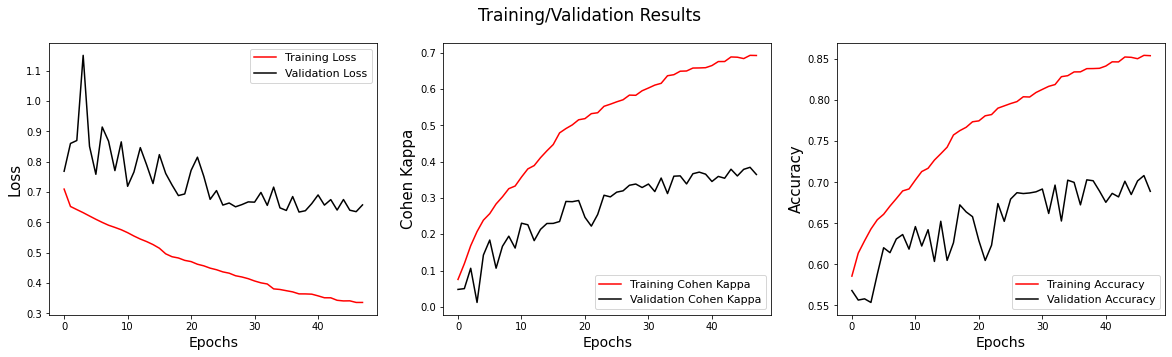

In [ ]:
plot_history(cnn_history.history)

In [ ]:
cnn_model.save('/content/drive/MyDrive/cnn_MURA')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/cnn_MURA/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/cnn_MURA/assets


In [ ]:
cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/cnn_MURA')

### DenseNet

In [ ]:
densenet = DenseNet169(
    weights='imagenet', 
    include_top=False,
    input_shape=(224,224,3)
)

for layer in densenet.layers:
    layer.trainable = False

gap = GlobalAveragePooling2D()(densenet.output)
output = Dense(units=1, activation='sigmoid')(gap)

densenet_model = Model(inputs=densenet.input, outputs=output)
densenet_model.compile(metrics=METRICS, optimizer=Adam(5e-3), loss='binary_crossentropy')
densenet_model.summary()

In [ ]:
densenet_callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5),
    ReturnBestEarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
]
history = densenet_model.fit(
    train_generator, 
    epochs=35,  
    callbacks=densenet_callbacks, 
    validation_data=val_generator
    )

Epoch 1/35
489/489 [==============================] - 524s 1s/step - loss: 0.5957 - cohen_kappa: 0.3191 - accuracy: 0.6838 - val_loss: 0.5686 - val_cohen_kappa: 0.4126 - val_accuracy: 0.7133 - lr: 0.0050
Epoch 2/35
489/489 [==============================] - 444s 907ms/step - loss: 0.5657 - cohen_kappa: 0.3823 - accuracy: 0.7122 - val_loss: 0.5543 - val_cohen_kappa: 0.4222 - val_accuracy: 0.7200 - lr: 0.0050
Epoch 3/35
489/489 [==============================] - 438s 895ms/step - loss: 0.5669 - cohen_kappa: 0.3825 - accuracy: 0.7111 - val_loss: 0.6193 - val_cohen_kappa: 0.3470 - val_accuracy: 0.7104 - lr: 0.0050
Epoch 4/35
489/489 [==============================] - 441s 901ms/step - loss: 0.5653 - cohen_kappa: 0.3957 - accuracy: 0.7171 - val_loss: 0.5424 - val_cohen_kappa: 0.4364 - val_accuracy: 0.7410 - lr: 0.0050
Epoch 5/35
489/489 [==============================] - 440s 900ms/step - loss: 0.5572 - cohen_kappa: 0.3979 - accuracy: 0.7183 - val_loss: 0.6096 - val_cohen_kappa: 0.3605 - va

In [ ]:
densenet_model.save('/content/drive/MyDrive/densenet_MURA')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/densenet_MURA/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/densenet_MURA/assets


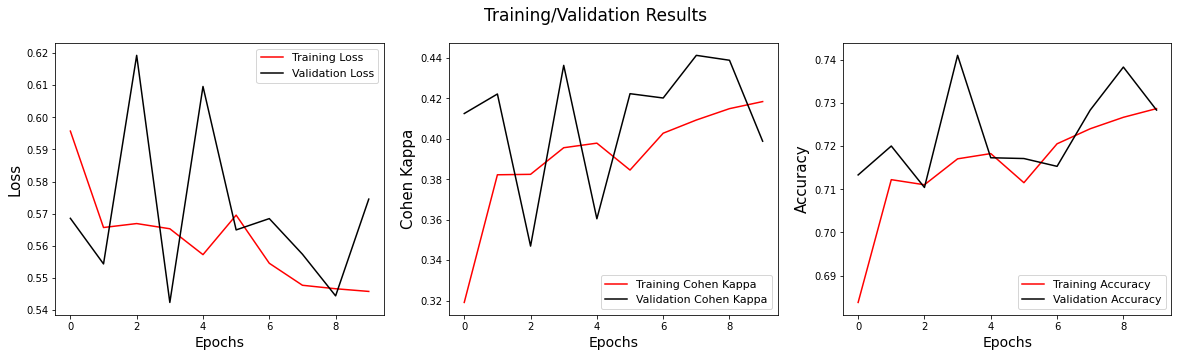

In [ ]:
plot_history(history.history)

In [ ]:
densenet_model = tf.keras.models.load_model('densenet_MURA')

In [ ]:
for layer in densenet_model.layers:
    layer.trainable = True

densenet_model.compile(optimizer=Adam(learning_rate=1e-5), metrics=METRICS, loss='binary_crossentropy')

In [ ]:
final_densenet_callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
]
history = densenet_model.fit(
    train_generator, 
    epochs=30,  
    callbacks=final_densenet_callbacks, 
    validation_data=val_generator,
    shuffle=True
)

Epoch 1/30
489/489 [==============================] - 607s 1s/step - loss: 0.5962 - cohen_kappa: 0.3976 - accuracy: 0.7153 - val_loss: 0.8146 - val_cohen_kappa: 0.3295 - val_accuracy: 0.6465 - lr: 1.0000e-05
Epoch 2/30
489/489 [==============================] - 562s 1s/step - loss: 0.5031 - cohen_kappa: 0.5092 - accuracy: 0.7683 - val_loss: 0.5043 - val_cohen_kappa: 0.5454 - val_accuracy: 0.7854 - lr: 1.0000e-05
Epoch 3/30
489/489 [==============================] - 561s 1s/step - loss: 0.4634 - cohen_kappa: 0.5548 - accuracy: 0.7897 - val_loss: 0.5452 - val_cohen_kappa: 0.5110 - val_accuracy: 0.7765 - lr: 1.0000e-05
Epoch 4/30
489/489 [==============================] - 561s 1s/step - loss: 0.4331 - cohen_kappa: 0.5887 - accuracy: 0.8056 - val_loss: 0.5181 - val_cohen_kappa: 0.5407 - val_accuracy: 0.7881 - lr: 1.0000e-05
Epoch 5/30
489/489 [==============================] - 560s 1s/step - loss: 0.4121 - cohen_kappa: 0.6183 - accuracy: 0.8198 - val_loss: 0.4741 - val_cohen_kappa: 0.5650 

In [ ]:
densenet_model.save('/content/drive/MyDrive/finetuned_densenet_MURA')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/finetuned_densenet_MURA/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/finetuned_densenet_MURA/assets


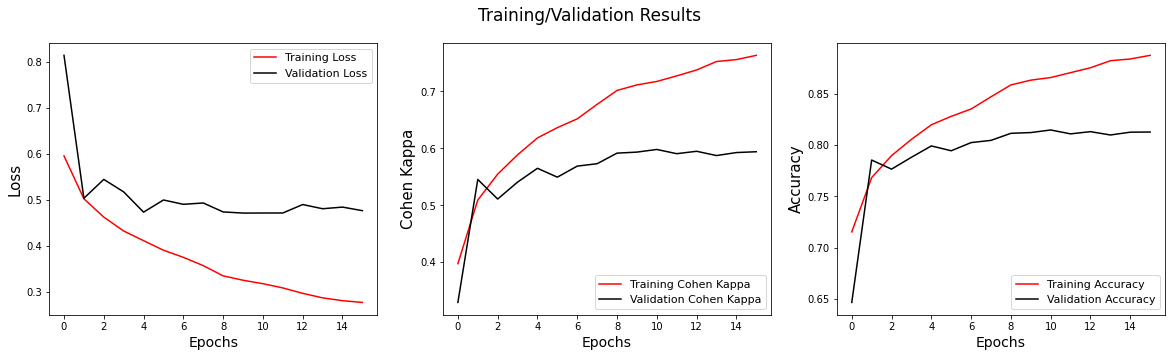

In [ ]:
plot_history(history.history)

In [ ]:
densenet_model = tf.keras.models.load_model('/content/drive/MyDrive/finetuned_densenet_MURA')

#### Error Analysis

In [ ]:
densenet_preds = densenet_model.predict(test_generator)
densenet_label_preds = np.where(densenet_preds > 0.5, 1, 0)

cnn_preds = cnn_model.predict(test_generator)
cnn_label_preds = np.where(cnn_preds > 0.5, 1, 0)

true_labels = test_data.label.to_numpy().astype(int)

In [ ]:
print(f'CNN cohen kappa: {cohen_kappa_score(true_labels, cnn_label_preds)}')
print(f'Densenet cohen kappa: {cohen_kappa_score(true_labels, densenet_label_preds)}')

CNN cohen kappa: 0.31510360050844144
Densenet cohen kappa: 0.5537430504334309


The pre-trained DenseNet model yields a 75% larger cohen kappa score than the CNN model. In particular, the DenseNet scored a 0.5537 cohen kappa, whereas the CNN scored 0.3151.

In [ ]:
print(f'CNN\'s Predictions:\n{classification_report(true_labels, cnn_label_preds)}\n')
print(f'Densenet\'s Predictions:\n{classification_report(true_labels, densenet_label_preds)}')

CNN's Predictions:
              precision    recall  f1-score   support

           0       0.64      0.81      0.71      1667
           1       0.71      0.50      0.59      1530

    accuracy                           0.66      3197
   macro avg       0.67      0.66      0.65      3197
weighted avg       0.67      0.66      0.65      3197


Densenet's Predictions:
              precision    recall  f1-score   support

           0       0.73      0.91      0.81      1667
           1       0.87      0.63      0.73      1530

    accuracy                           0.78      3197
   macro avg       0.80      0.77      0.77      3197
weighted avg       0.80      0.78      0.77      3197



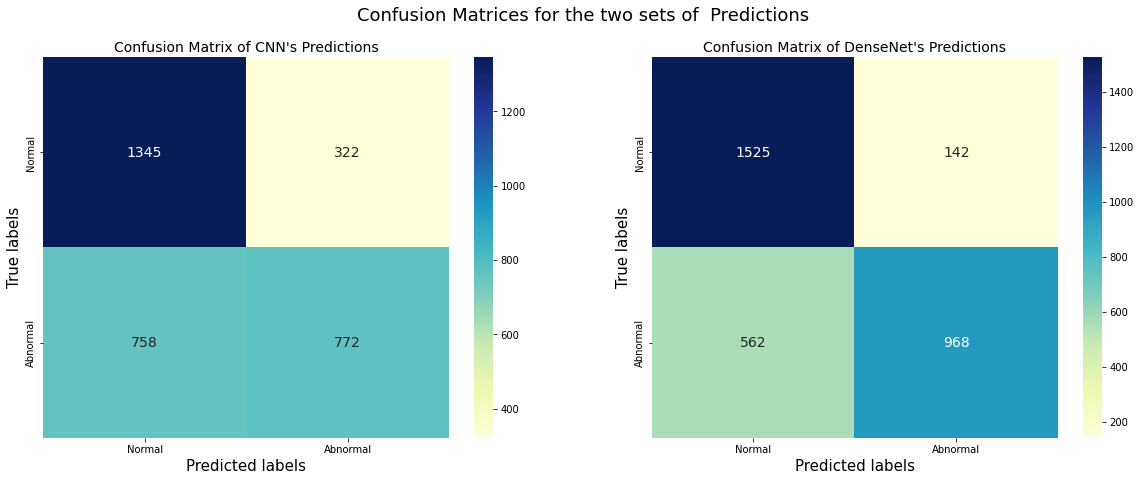

In [ ]:
plot_cm(true_labels, [cnn_label_preds, densenet_label_preds], '')

CNN's accuracy score is equal to 66%, whereas the DenseNet scored an accuracy equal to 78%.

The CNN model seems to misclassify many abnormal X-RAYs, which resulted in a recall and f1 score (for the abnormal class) equal to 50% and 59% respectively and a precision score (for the normal class) equal to 64%. 

DenseNet's misclassifications for the abnormal class were also high but significantly less than those of CNN's. That led to an improvement on the aforementioned scores (63%, 73% and 73% respectively). The misclassifications for the normal class were also substantially better with the DenseNet model (less than half of the CNN's).

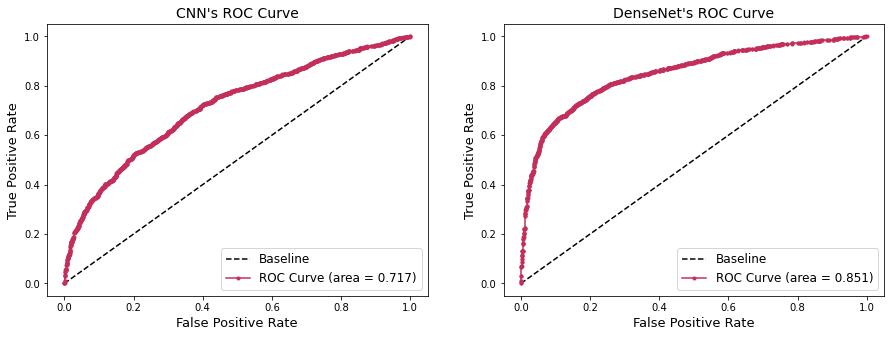

In [ ]:
roc_auc_plot(true_labels, [cnn_preds, densenet_preds], ['CNN\'s', 'DenseNet\'s'])

The ROC-AUC score is also larger for the DenseNet model (85.1%), which means that it can, more effectively, distinguish the two classes.

### Body Parts

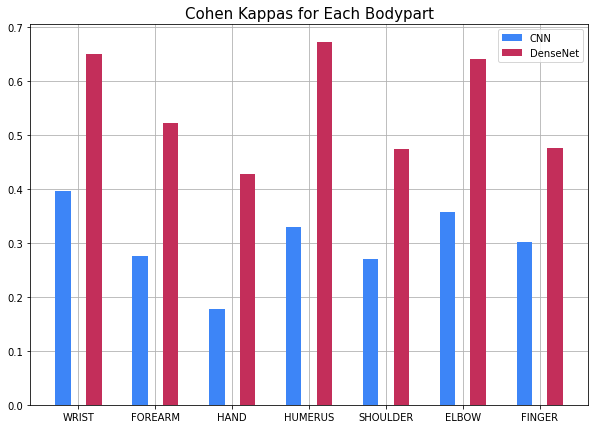

In [ ]:
kappa_bodypart_plot(test_data, cnn_label_preds, densenet_label_preds)

It seems that for the pre-trained DenseNet model, X-RAYs from humeri, wrists and elbows had the best cohen kappa scores (above 0.6), whereas hands, fingers and shoulders had the lowest cohen kappa score (under 0.5).

As for the CNN model, wrist X-RAYs had the highest cohen kappa score (nearly 0.4), however it was lower than the worst performing bodypart of the DenseNet model. Thus, it can be safely inferred that the DenseNet's architecture, along with its transferred knowledge had a significant impact to the results.

### Wrist X-RAYs

CNN cohen kappa: 0.39688834655277616
Densenet cohen kappa: 0.6500600383671478

CNN's Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.84      0.76       364
           1       0.73      0.55      0.63       295

    accuracy                           0.71       659
   macro avg       0.71      0.69      0.69       659
weighted avg       0.71      0.71      0.70       659


DenseNet's Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.96      0.86       364
           1       0.93      0.67      0.78       295

    accuracy                           0.83       659
   macro avg       0.86      0.82      0.82       659
weighted avg       0.85      0.83      0.83       659




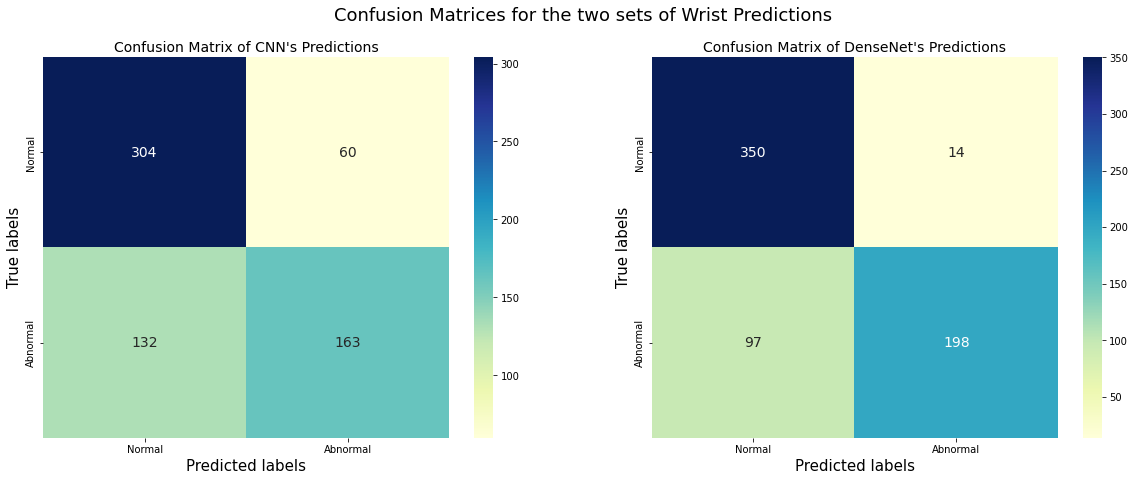

In [ ]:
bodypart_errors(cnn_label_preds, densenet_label_preds, test_data, 'XR_WRIST')

Wrists had the second best cohen kappa score (0.65). The CNN model produced a cohen kappa score equal to 0.396, which was the best among the CNN's predictions.

Accuracy was equal to 0.83 for the DenseNet model and 0.71 for the CNN model. Both models seem to have a slightly high number of missclassifications for the abnormal class (false negatives). That led to a recall score equal to 0.55 for the CNN and 0.67 for the DenseNet model.

The misclassifications of the normal class were 4 times less for the DenseNet model (14 as opposed to 60 from the CNN model).

### Forearm XRAYs

CNN cohen kappa: 0.27661779296659683
Densenet cohen kappa: 0.5223064715217776

CNN's Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.82      0.69       150
           1       0.72      0.46      0.56       151

    accuracy                           0.64       301
   macro avg       0.66      0.64      0.63       301
weighted avg       0.66      0.64      0.63       301


DenseNet's Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.99      0.80       150
           1       0.98      0.54      0.69       151

    accuracy                           0.76       301
   macro avg       0.83      0.76      0.75       301
weighted avg       0.83      0.76      0.75       301




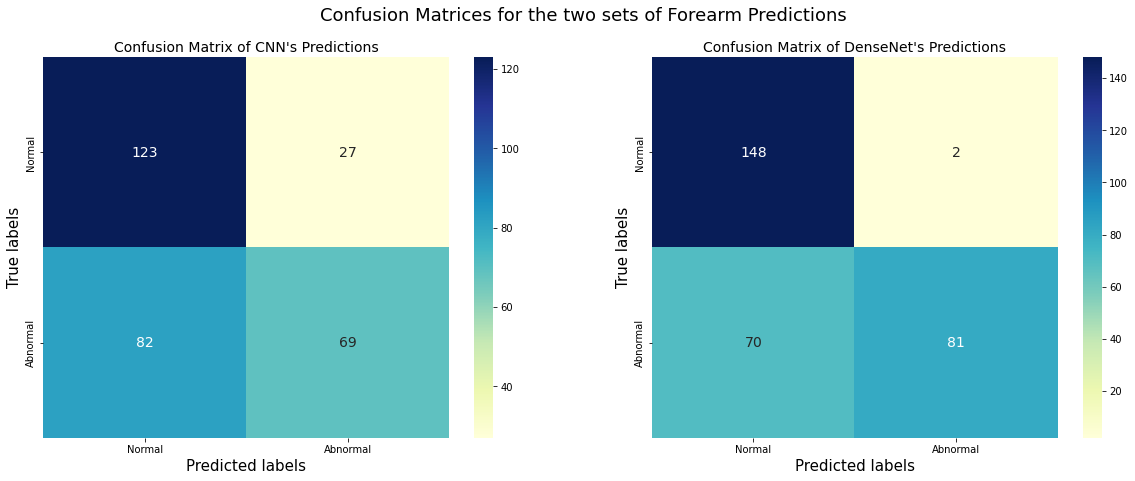

In [ ]:
bodypart_errors(cnn_label_preds, densenet_label_preds, test_data, 'XR_FOREARM')

As for the Forearm X-RAYs, the cohen kappa scores were average. In particular, the DenseNet model scored 0.52 which was the 4th lowest score, whereas the CNN model scored 0.276, which was the 5th lowest score (among the CNN predictions).

Accuracy for the DenseNet model was equal to 0.76, whereas for the CNN model it was equal to 0.64. Again, the number of the misclassified abnormal X-RAYs was quite large. For the CNN model it was even greater than the correctly classified ones (82 as opposed to 69). That led to a recall score of 0.46. There was an improvment with the DenseNet model (81 true positives and 70 false negatives) which led to a recall score of 0.54.

As for the normal X-RAYs, the DenseNet performed incredibly well, having only 2 false positives (recall=0.99), as opposed to 27 from the CNN model.

###Hand X-RAYs

CNN cohen kappa: 0.17827088220734788
Densenet cohen kappa: 0.4275974569181864

CNN's Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.91      0.75       271
           1       0.66      0.25      0.37       189

    accuracy                           0.64       460
   macro avg       0.65      0.58      0.56       460
weighted avg       0.64      0.64      0.59       460


DenseNet's Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.93      0.81       271
           1       0.83      0.47      0.60       189

    accuracy                           0.74       460
   macro avg       0.77      0.70      0.70       460
weighted avg       0.76      0.74      0.72       460




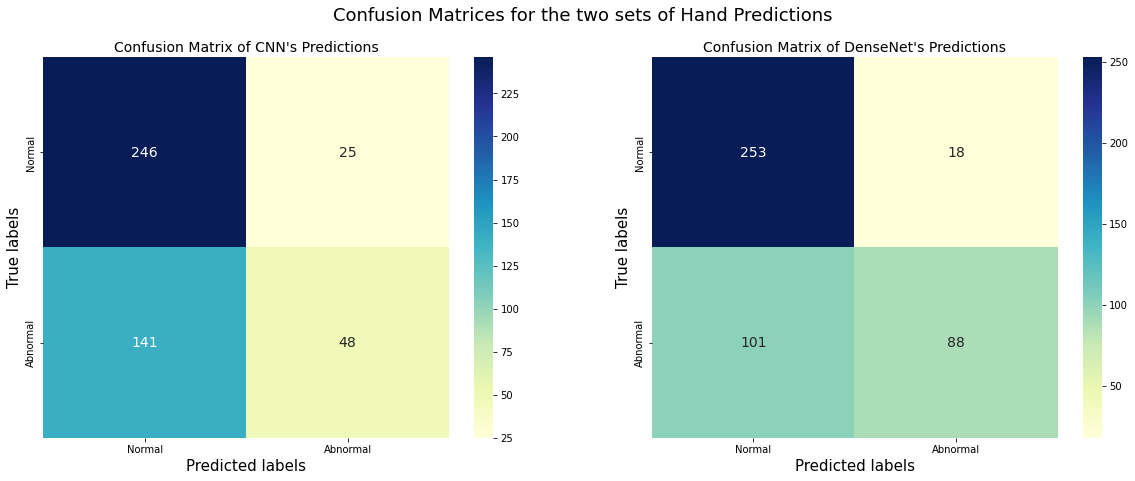

In [ ]:
bodypart_errors(cnn_label_preds, densenet_label_preds, test_data, 'XR_HAND')

Hand X-RAYs produced the worst cohen kappa scores for both models. The CNN model yielded a score equal to ~0.17, whereas the DenseNet yielded a score equal to ~0.43.

The CNN model scored a 0.64 accuracy, whereas the DenseNet scored 0.74.
Both models had more false negatives than true positives, which lead to substantially low recall scores (0.25 for the CNN model and 0.47 for the DenseNet model).

The predictions for the normal X-RAYs were decent.

### Humerus X-RAYs

CNN cohen kappa: 0.32997285769678164
Densenet cohen kappa: 0.6720294630742392

CNN's Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.75      0.70       148
           1       0.69      0.58      0.63       140

    accuracy                           0.67       288
   macro avg       0.67      0.66      0.66       288
weighted avg       0.67      0.67      0.66       288


DenseNet's Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       148
           1       0.89      0.76      0.82       140

    accuracy                           0.84       288
   macro avg       0.84      0.83      0.84       288
weighted avg       0.84      0.84      0.84       288




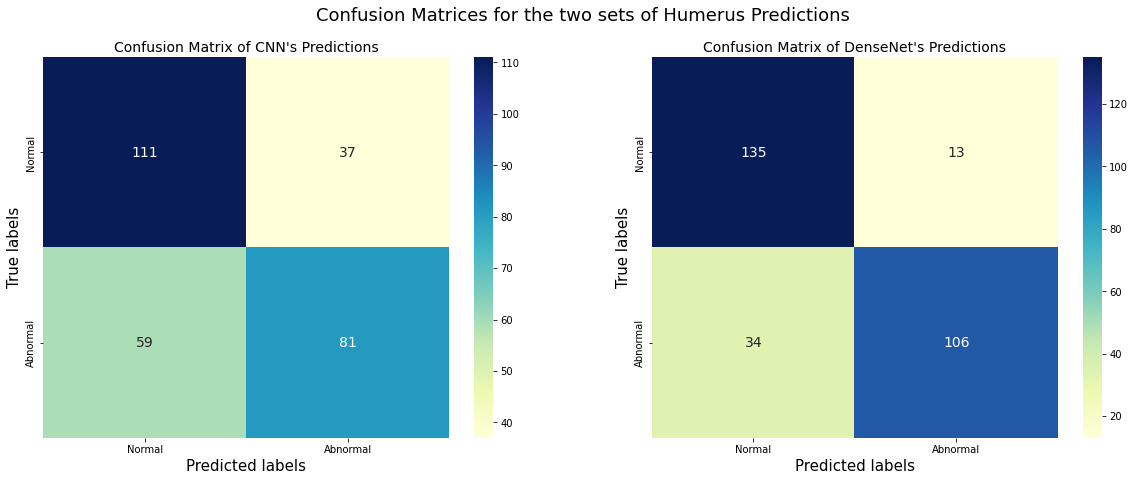

In [ ]:
bodypart_errors(cnn_label_preds, densenet_label_preds, test_data, 'XR_HUMERUS')

Humerous was the bodypart whose X-RAYs produced the highest overall cohen kappa score. The DenseNet model produced a score equal to 0.67, whereas the CNN produced a score equal to 0.33 (3rd largest among the CNN predictions).

The CNN had an accuracy score of 0.67, whereas the DenseNet model had an accuracy score of 0.84. The DenseNet also produced the highest recall score out of all the bodyparts (0.76). CNN's recall score for the abnormal class was also the highest among all the body parts (0.58).

The scores were great probably due to the fact that there was not a significant imbalance among the classes for these types of X-RAYs.

### Shoulder X-RAYs

CNN cohen kappa: 0.2703888435838596
Densenet cohen kappa: 0.4741638268332702

CNN's Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.71      0.66       285
           1       0.65      0.56      0.60       278

    accuracy                           0.64       563
   macro avg       0.64      0.63      0.63       563
weighted avg       0.64      0.64      0.63       563


DenseNet's Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.74      0.74       285
           1       0.73      0.73      0.73       278

    accuracy                           0.74       563
   macro avg       0.74      0.74      0.74       563
weighted avg       0.74      0.74      0.74       563




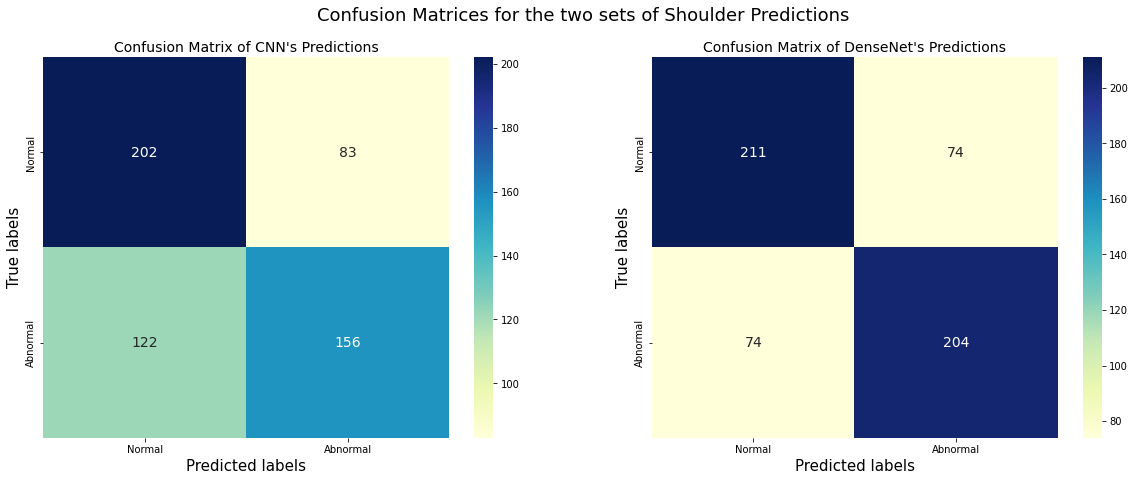

In [ ]:
bodypart_errors(cnn_label_preds, densenet_label_preds, test_data, 'XR_SHOULDER')

Shoulder X-RAYs had the 6th lower cohen kappa score among the DenseNet's predictions. In particular, it was equal to 0.474, whereas for the CNN model it was equal to 0.27.

Accuracy was 10% higher for the DenseNet model (74% as opposed to 64%). The DenseNet model, also produced the second highest recall score for the abonrmal class (0.73 for the DenseNet model and 0.56 for the CNN model). Again, the high recall scores might have been produced due to the lack of class imbalance for this bodypart. 

###Elbow X-RAYs

CNN cohen kappa: 0.35689423121548247
Densenet cohen kappa: 0.6418596019115668

CNN's Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.84      0.73       235
           1       0.76      0.52      0.61       230

    accuracy                           0.68       465
   macro avg       0.70      0.68      0.67       465
weighted avg       0.70      0.68      0.67       465


DenseNet's Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.97      0.85       235
           1       0.95      0.67      0.79       230

    accuracy                           0.82       465
   macro avg       0.85      0.82      0.82       465
weighted avg       0.85      0.82      0.82       465




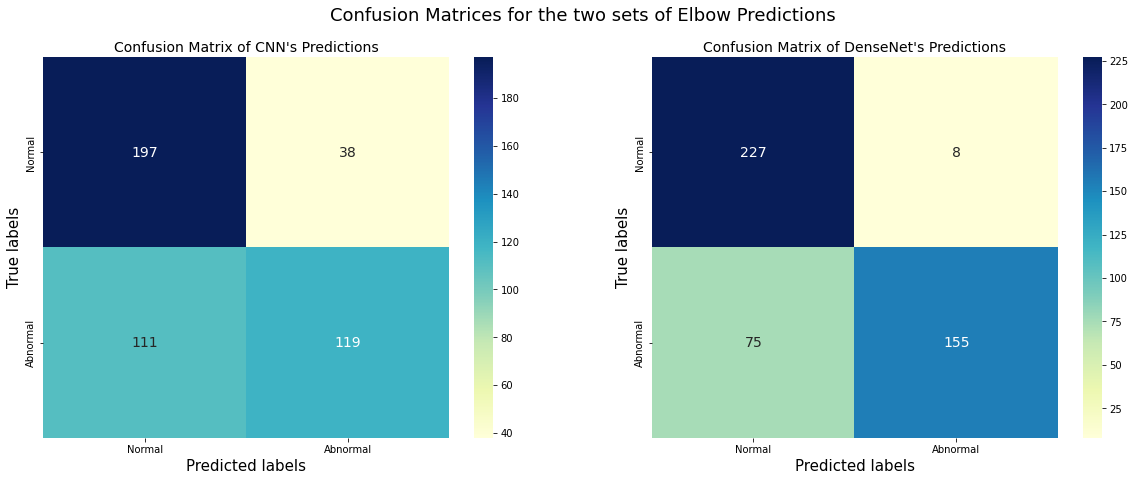

In [ ]:
bodypart_errors(cnn_label_preds, densenet_label_preds, test_data, 'XR_ELBOW')

Elbow X-RAYs had the 3rd largest cohen kappa score. The DenseNet model scored 0.64, whereas the CNN model scored 0.35 (2nd highest among the CNN predictions).

The DenseNet model scored an acuuracy score equal to 82%, whereas the CNN model scored 68%.

Like the rest of the bodyparts, the models had a hard time classifying abnormal X-RAYs. In particular, the CNN model had 111 false negatives and 119 true positives (recall=0.52), whereas the DenseNet model had 75 false negatives and 155 true positives (recall=0.67).

### Finger X-RAYs

CNN cohen kappa: 0.3020536303093915
Densenet cohen kappa: 0.47531895364846255

CNN's Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.76      0.67       214
           1       0.72      0.55      0.63       247

    accuracy                           0.65       461
   macro avg       0.66      0.65      0.65       461
weighted avg       0.66      0.65      0.64       461


DenseNet's Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.94      0.76       214
           1       0.91      0.55      0.69       247

    accuracy                           0.73       461
   macro avg       0.78      0.74      0.73       461
weighted avg       0.79      0.73      0.72       461




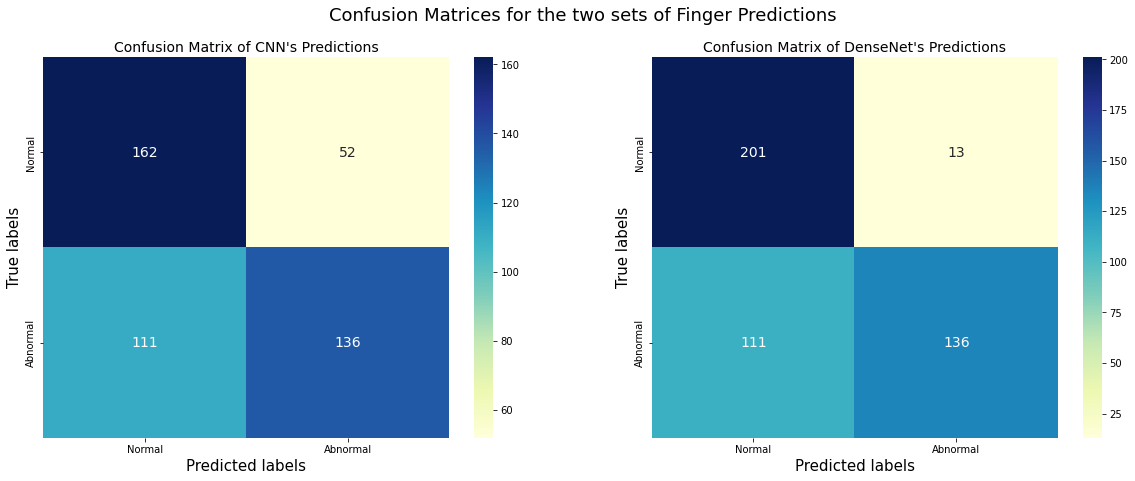

In [ ]:
bodypart_errors(cnn_label_preds, densenet_label_preds, test_data, 'XR_FINGER')

Finger X-RAYs had the 4th lower cohen kappa score. The DenseNet model produced a score equal to 0.475, whereas the CNN model scored 0.3.

The accuracy score of the DenseNet model was equal to 73%, whereas the CNN model scored 65%.

Both models had the same number of false negatives (111), which resulted to a recall score equal to 0.55. However, Densenet's false positives were siginificantly lower (12 as opposed to 52).